In [71]:
import random
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pickle
import os
import torchaudio

from torchaudio.transforms import MelSpectrogram

N_SAMPLES=25500 #fixed length

paths=[]
labels=[]
label_list=['808s','Claps','Closed Hats','Crashes & Cymbals','Extras','FX','Kicks','Open Hats','Percs','Snares','Vox']
data_dir= './data'
for root, subdirs, files in os.walk(data_dir):
    if len(files)>0:
        label=os.path.basename(os.path.normpath(root))
        if label in label_list:
            for file in files:
                if file[-3:]=='wav' or file[-3:]=='WAV':
                    labels.append(label)
                    paths.append(os.path.join(root, file))


c = list(zip(paths, labels))
random.Random(42).shuffle(c)
paths, labels = zip(*c)

val_paths=paths[:len(paths)//10]
val_labels=labels[:len(paths)//10]

train_paths=paths[len(paths)//10:]
train_labels=labels[len(paths)//10:]
print(len(train_paths),len(val_paths))



class AudioDataset(Dataset):
    
    def __init__(self, mypaths, mylabels,transform=None):
        self.paths=mypaths
        self.labels=mylabels
        self.n_samples=len(mypaths)
        self.label_list=label_list
    def __getitem__(self, index):
        waveform, sample_rate = torchaudio.load(self.paths[index], normalize=True)
        waveform = torch.mean(waveform, dim=0).unsqueeze(0) #mono
        #
        # to fixed length
        target = torch.zeros(1, N_SAMPLES)
        target[:,:min(waveform.shape[1],N_SAMPLES) ] = waveform[:,:min(waveform.shape[1],N_SAMPLES)]
        waveform=target
        
        #mel, expand for resnet to 3 channels
        mel = MelSpectrogram(sample_rate)(waveform)

        return  mel.expand(3,-1,-1), torch.tensor(self.label_list.index(self.labels[index]))

   
    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples


1012 112


In [72]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torchaudio
cudnn.benchmark = True
plt.ion()   # interactive mode



audio_datasets = {'train': AudioDataset(train_paths,train_labels),'val': AudioDataset(val_paths,val_labels)}
dataloaders = {x: torch.utils.data.DataLoader(audio_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(audio_datasets[x]) for x in ['train', 'val']}
class_names = label_list

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

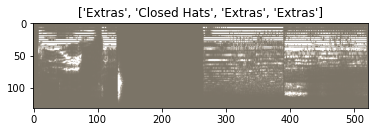

In [73]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [65]:
dataset_sizes

{'train': 1012, 'val': 112}

In [74]:
from tqdm import tqdm
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase],position=0,leave=True):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [75]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [76]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names)) #classes

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [77]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


100%|████████████████████████████████████████████████████████████████████████████████| 253/253 [00:06<00:00, 39.21it/s]


train Loss: 1.3917 Acc: 0.5573


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 36.22it/s]


val Loss: 1.7257 Acc: 0.5268

Epoch 1/24
----------


100%|████████████████████████████████████████████████████████████████████████████████| 253/253 [00:06<00:00, 38.65it/s]


train Loss: 1.0311 Acc: 0.6581


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 71.33it/s]


val Loss: 1.4785 Acc: 0.7411

Epoch 2/24
----------


100%|████████████████████████████████████████████████████████████████████████████████| 253/253 [00:06<00:00, 40.87it/s]


train Loss: 0.8387 Acc: 0.7213


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 70.08it/s]


val Loss: 1.1905 Acc: 0.6875

Epoch 3/24
----------


 56%|████████████████████████████████████████████▌                                   | 141/253 [00:03<00:02, 37.98it/s]


KeyboardInterrupt: 